In [211]:
from numpy import *
from graphviz import Digraph
from IPython.display import Image
from sklearn.datasets import load_breast_cancer

In [212]:
g = Digraph("Network")
NodeCollection = []
Variables = []
counter = 0
dt = 0.01
def toNode(other,draw=True):
    name = None
    if isinstance(other,Node):
        return other
    if type(other) != ndarray:
        if type(other) != iterable:
            name = str(other)
            other = array([other])
        else:
            other = array(other)
    return Constant(other,name,draw)
class Node:
    name = None
    COLOR = "black"
    def __init__(self,name=None,draw=True):
        global counter,NodeCollection
        self.value = None
        self.outputNodes = []
        self.inputNodes = []
        self.id = counter
        self.draw = draw
        if self.name==None and name == None:
            self.name = str(self.id)
        elif name!=None:
            self.name = name
        if draw:
            g.node(str(self.id),self.name,color=self.COLOR)
        NodeCollection.append(self)
        counter += 1
    def __repr__(self):
        return f"name : {self.name}\n value : \n{self.value}\n grad : \n{self.grad}\n"
    def __add__(self,other):
        return Add([self,toNode(other)],"+")
    def __mul__(self,other):
        return Mul([self,toNode(other)],"*")
    def __pow__(self,other):
        return Pow([self,toNode(other)],"**")
    def __div__(self,other):
        return self*(other**(-1))
    def __neg__(self):
        return Neg([self],"-")
    def __sub__(self,other):
        return self + (-toNode(other))
    def recieve(self):
        self.grad = 0
        for n in self.outputNodes:
            DFDX = n.dfdx_value[self.id]
            GRAD = n.grad
            #print("recievong from",n.id,"aka",n.name)
            #print("DFDX",DFDX.shape)
            #print("GRAD",GRAD.shape)
            if DFDX.shape==(1,) or GRAD.shape ==(1,):
                self.grad += GRAD*DFDX
            else:
                #self.grad += dot(GRAD,DFDX)
                self.grad += GRAD @ DFDX
class Function(Node):
    COLOR = "green"
    f = None
    dfdx = None
    dfdx_value = None
    def __init__(self,inputNodes,name=None,draw=True):
        super().__init__(name,draw)
        for n in inputNodes:
            if self.draw and n.draw:
                g.edge(str(n.id),str(self.id))
            n.outputNodes.append(self)
        self.inputNodes = inputNodes
        self.forward()
    def __repr__(self):
        return f"name : {self.name}\n value : \n{self.value}\n grad : \n{self.grad}\n dfdx : \n{self.dfdx}\n"
    def forward(self):
        self.inputs = dict([(node.id,node.value) for node in self.inputNodes])
        self.value = self.f(self.inputs)
        self.dfdx_value = self.dfdx(self.inputs)
        n = prod(self.value.shape)
        #if n > 1:
        #    self.grad = identity(n)    
        #else :
        #    self.grad = array(1)
        self.grad = identity(n)
    def backward(self):
        for n in self.inputNodes:
            n.recieve()
            n.backward()
class Variable(Node):
    COLOR = "red"
    def __init__(self,value,name=None,draw=True):
        super().__init__(name,draw)
        self.value = value
        n = prod(self.value.shape)
        self.grad = identity(n)
        Variables.append(self)
    def backward(self):
        pass
    def forward(self):
        global dt
        self.value -= self.grad[0]*dt
class Constant(Variable):
    COLOR="black"
    def recieve(self):
        pass
    def forward(self):
        pass

class Add(Function):
    name = "+"
    def f(self,inputs):
        S = 0
        for id in inputs:
            S += inputs[id]
        return S
    def dfdx(self,inputs):
        G = dict()
        for id in inputs:
            n = prod(inputs[id].shape)
            if n>1:
                G[id] = identity(n)
            else:
                G[id] = ones(prod(self.value.shape))[:,newaxis]
        return G
class Mul(Function):
    name = "*"
    def f(self,inputs):
        S = 1
        for id in inputs:
            S = S*inputs[id]
        return S
    def dfdx(self,inputs):
        G = dict()
        for id in inputs:
            S = 1
            for Id in inputs:
                if Id == id:
                    continue
                S = S*inputs[Id]
            S = S.flatten()
            n = prod(inputs[id].shape)
            if n > 1:
                m, = S.shape
                if m > 1:
                    S = diag(S)
                else :
                    S = S * identity(n)
            else:
                S = S[:,newaxis]
            G[id] = S
        return G
class Exp(Function):
    name = "exp"
    def f(self,inputs):
        return exp(next(iter(inputs.values())))
    def dfdx(self,inputs):
        id = next(iter(inputs.keys()))
        x = next(iter(inputs.values()))
        n = prod(x.shape)
        x = exp(x)
        x = x.flatten()
        if n>1:
            return {id:diagflat(x)}
        return {id:x[:,newaxis]}
class Pow(Function):
    name = "**"
    def f(self,inputs):
        x,n = inputs.values()
        return x**n
    def dfdx(self,inputs):
        ids = list(inputs.keys())
        x,n = inputs.values()
        m = prod(x.shape)
        if m > 1:
            return {ids[0]:diagflat(n*x**(n-1))}#,ids[1]:(log(x)*x**n).flatten()[:,newaxis]}
        return {ids[0]:(n*x**(n-1)).flatten()[:,newaxis]}#,ids[1]:(log(x)*x**n).flatten()[:,newaxis]}
class Neg(Function):
    name = "-"
    def f(self,inputs):
        return -next(iter(inputs.values()))
    def dfdx(self,inputs):
        id = next(iter(inputs.keys()))
        x = next(iter(inputs.values()))
        n = prod(x.shape)
        #if n>1:
        #    return {id:-identity(n)}
        #return {id:-array([1])}
        return {id:-identity(n)}
class Dot(Function):
    name = "."
    def f(self,inputs):
        x,y = inputs.values()
        d = dot(x,y)
        if len(d.shape)>0:
            return d
        return array([d])
    def dfdx(self,inputs):
        id1,id2 = inputs.keys()
        x,y = inputs.values()
        if len(x.shape) == 1:
            x = x[newaxis,:]
            y = y[newaxis,:]
        return {id1:y,id2:x}
class Sum(Function):
    name = "sum"
    def f(self,inputs):
        x, = inputs.values()
        return array([sum(x)])
    def dfdx(self,inputs):
        x, = inputs.values()
        id, = inputs.keys()
        n = prod(x.shape)
        return {id:ones((1,n))}

def Sigm(inputNode,name="S",draw=True):
    out = Neg([inputNode],None,False)
    out = Exp([out],None,False)
    out = Add([out,Constant(array([1]),None,False)],None,False)
    out = Pow([out,Constant(array([-1]),None,False)],name,True)
    if draw and inputNode.draw:
        g.edge(str(inputNode.id),str(out.id))
    return out
def perceptron(layer,draw=True):
    nl = []
    for n in layer :
        nl.append(Mul([n,Variable(random.random(1),None,False)],None,False))
    S = Add(nl,"+",False)
    S = Sigm(S,"P",draw)
    for n in layer:
        if draw and n.draw:
            g.edge(str(n.id),str(S.id))
    S.nl = nl
    return S
def SqEr(inputNodes,name="L",draw=True):
    x,y = inputNodes
    out = Neg([y],None,False)
    out = Add([x,out],None,False)
    two = Constant(array([2]),None,False)
    out = Pow([out,two],None,False)
    out = Sum([out],name,draw)
    for n in inputNodes:
        if draw and n.draw:
            g.edge(str(n.id),str(out.id))
    return out
def BacProp():
    global NodeCollection
    for i in range(len(NodeCollection)-2,-1,-1):
        n=NodeCollection[i]
        #print(i,n.name)
        n.recieve()
        #if isinstance(n,Function):
        #    print(n.dfdx_value)
        #    print(n.grad)
        #print("\n")
def forProp():
    global NodeCollection
    for i in range(len(NodeCollection)):
        n=NodeCollection[i]
        n.forward()
def Descend(iterations=100,alpha=2,dt_init=10**-10):
    global dt,NodeCollection,Variables
    L = NodeCollection[-1]
    print("before",L.value)
    for i in range(iterations):
        dt = dt_init
        BacProp()
        oldL = L.value
        forProp()
        while (oldL-L.value)[0] >= 0.5*(dt)*sum([linalg.norm(n.grad) for n in Variables]):
            dt *= alpha
            oldL = L.value
            forProp()
        dt = -dt
        forProp()
        dt = -dt
        if dt == dt_init:
            print("breaking after ",i,"iterations")
            break
    print("after",L.value)
def Reset():
    global g,NodeCollection,Variables,counter,dt
    g = Digraph("Network")
    NodeCollection = []
    Variables = []
    counter = 0
    dt = 0.01
def Show(g,w=100):
    display(Image(g.pipe("png"),width=w))
def sigmoid(x):
    return 1/(1+exp(-x))

class Net:
    def __init__(self,LS=[3,3,3]):
        Reset()
        n = LS.pop(0)
        layer0 = [Constant(ones(1)) for _ in range(n)]
        layers = [layer0]
        for n in LS:
            last_layer = layers[-1]
            layers.append([perceptron(last_layer) for _ in range(n)])
        P = perceptron(layers[-1])
        y = Constant(ones(1),"y")
        L = SqEr([P,y])
        self.y = y
        self.layer0 = layer0
        self.P = P
        self.L = L
        self.layers = layers
    def assign(self,X,y):
        if X.shape[1]!= len(self.layer0):
            print("Can't deal with this many variables.")
            return
        self.y.value = y
        for c in range(X.shape[1]):
            self.layer0[c].value = X[:,c]
        forProp()
    def predict(self):
        forProp()
        loss = self.L.value
        y_pred = self.P.value
        return y_pred,loss


before [7.39729912]
breaking after  1 iterations
after [1.55532204]


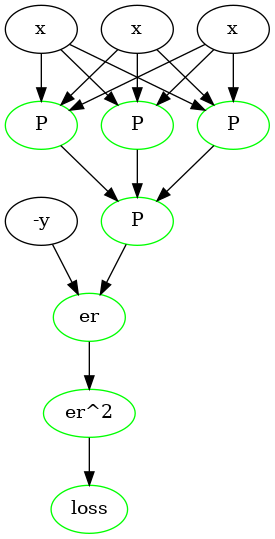

In [224]:
Reset()
N = 100
layer1 = [Constant(random.random(N),"x") for _ in range(3)]
layer2 = [perceptron(layer1) for _ in range(3)]
y = around(sigmoid(sum([random.random()*n.value for n in layer1]) + 0.5*random.random(N)))
my = Constant(-y,"-y")
P = perceptron(layer2)
er = Add([P,my],"er")
er2 = Pow([er,Constant(array([2]),None,False)],"er^2")
L = Sum([er2],"loss")
Descend(100,3,10**-10)
Show(g,150)

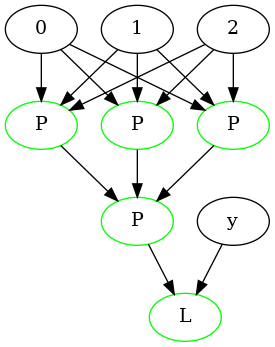

In [223]:
Reset()
N = 100
X = random.random((N,3))
y = sigmoid(dot(X,-5+10*random.random(3))+random.random(N))
net = Net([3,3])
net.assign(X,y)
Show(g,150)

before [45.28677295]
breaking after  1 iterations
after [22.75932548]


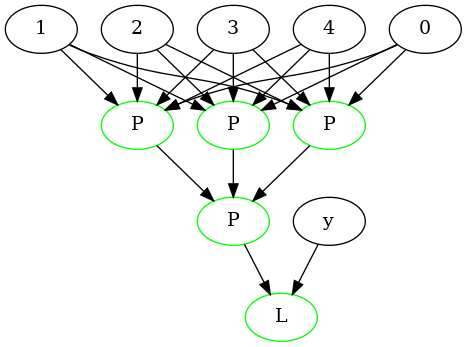

In [221]:
X,y = load_breast_cancer(return_X_y=True)
X = X[:100,:5]
y = y[:100]
net = Net([5,3])
net.assign(X,y)
Descend()
Show(g,200)

before [0.99876257]
breaking after  0 iterations
after [0.99876257]


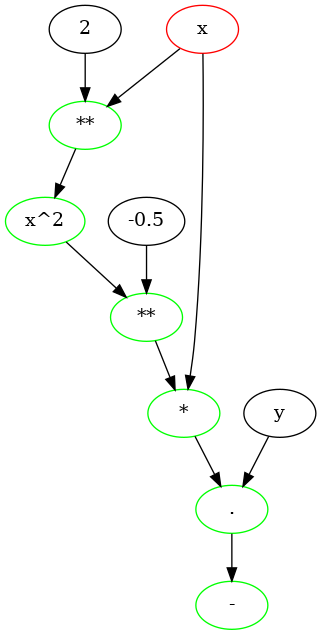

In [219]:
Reset()
x = Variable(-ones(2)/sqrt(2)+0.1*random.random(2),"x")
y = Constant(ones(2)/sqrt(2),"y")
xhat = x*Sum([x**2],"x^2")**-0.5
a = -Dot([xhat,y])
Descend()
Show(g,150)